In [3]:
import glob

import metpy
import xarray as xr
import matplotlib.pyplot as plt

## Vapour pressure

#### Read AWRA data

In [4]:
awra_vp_files = sorted(glob.glob('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/vapour_pressure/vapour_pressure_*.nc'))

In [5]:
awra_vp_files[66]

'/g/data/fj8/BoM/AWRA/DATA/CLIMATE/vapour_pressure/vapour_pressure_2016.nc'

In [6]:
ds_awra_vp = xr.open_mfdataset(awra_vp_files[66])

#### Read AGCD data

In [7]:
#agcd_vp9am_files = sorted(glob.glob('/g/data/xv83/agcd-csiro/vp-9am/daily/vp-9am_AGCD-CSIRO_r005_*_daily.nc'))
#agcd_vp9am_files[45]
agcd_vp9am_file = '/g/data/zv2/agcd/v1-0-1/vapourpres_h09/mean/r005/01day/agcd_v1-0-1_vapourpres_h09_mean_r005_daily_2016.nc'

In [8]:
ds_agcd_vp9am = xr.open_dataset(agcd_vp9am_file)

In [9]:
#agcd_vp3pm_files = sorted(glob.glob('/g/data/xv83/agcd-csiro/vp-3pm/daily/vp-3pm_AGCD-CSIRO_r005_*_daily.nc'))
#agcd_vp3pm_files[45]
agcd_vp3pm_file = '/g/data/zv2/agcd/v1-0-1/vapourpres_h15/mean/r005/01day/agcd_v1-0-1_vapourpres_h15_mean_r005_daily_2016.nc'

In [10]:
ds_agcd_vp3pm = xr.open_dataset(agcd_vp3pm_file)

In [11]:
daily_vapourpres = (ds_agcd_vp9am['vapourpres'].values * 0.2) + (ds_agcd_vp3pm['vapourpres'].values * 0.8)

In [12]:
coords = {
    'time': ds_agcd_vp9am['time'],
    'lat': ds_agcd_vp9am['lat'],
    'lon': ds_agcd_vp9am['lon'],
}

da_agcd_vp = xr.DataArray(
    data = daily_vapourpres,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
    attrs = ds_agcd_vp9am['vapourpres'].attrs
)

ds_agcd_vp = xr.Dataset({'vapourpres': da_agcd_vp}, attrs=ds_agcd_vp9am.attrs)

In [13]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

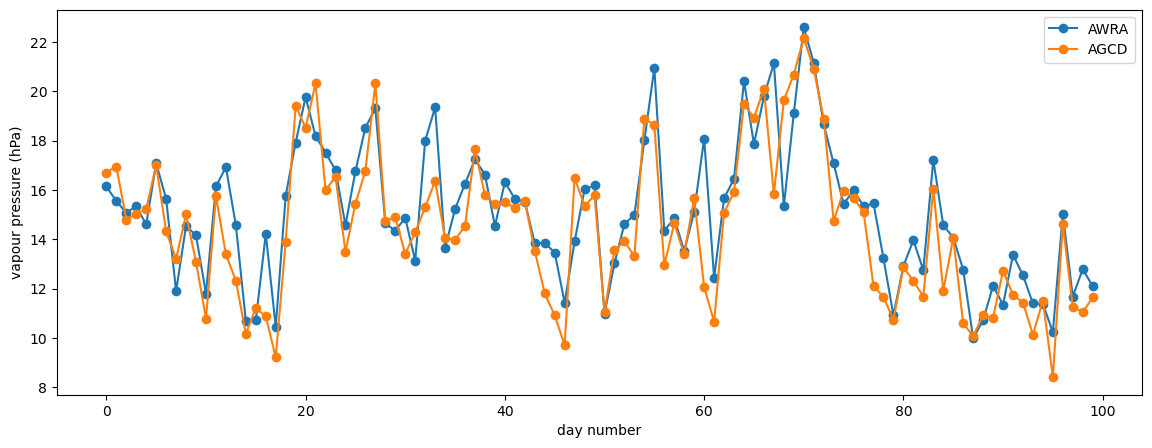

In [14]:
lat, lon = city_lat_lon['Melbourne']
point_awra_vp = ds_awra_vp['vapour_pressure'].sel({'latitude': lat, 'longitude': lon}, method='nearest')
point_agcd_vp = ds_agcd_vp['vapourpres'].sel({'lat': lat, 'lon': lon}, method='nearest')

fig = plt.figure(figsize=[14, 5])
plt.plot(point_awra_vp.values[0:100], marker='o', label='AWRA')
plt.plot(point_agcd_vp.values[0:100], marker='o', label='AGCD')

plt.ylabel('vapour pressure (hPa)')
plt.xlabel('day number')
plt.legend()
plt.show()

## Relative humidity

In [15]:
agcd_tmin_file = '/g/data/zv2/agcd/v1-0-1/tmin/mean/r005/01day/agcd_v1-0-1_tmin_mean_r005_daily_2016.nc'
agcd_tmax_file = '/g/data/zv2/agcd/v1-0-1/tmax/mean/r005/01day/agcd_v1-0-1_tmax_mean_r005_daily_2016.nc'

In [16]:
ds_agcd_tmin = xr.open_dataset(agcd_tmin_file)
ds_agcd_tmax = xr.open_dataset(agcd_tmax_file)

In [17]:
daily_tas = (ds_agcd_tmin['tmin'].values[1:] * 0.15) + (ds_agcd_tmax['tmax'].values[:-1] * 0.85)

In [18]:
coords = {
    'time': ds_agcd_tmin['time'][1:],
    'lat': ds_agcd_tmin['lat'],
    'lon': ds_agcd_tmin['lon'],
}

da_agcd_tas = xr.DataArray(
    data = daily_tas,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
    attrs = ds_agcd_tmin['tmin'].attrs
)
del da_agcd_tas.attrs['cell_methods']
da_agcd_tas.attrs['long_name'] = 'Daily weighted mean air temperature'
da_agcd_tas.attrs['units'] = 'degC'

ds_agcd_tas = xr.Dataset({'tas': da_agcd_tas}, attrs=ds_agcd_tmin.attrs)

In [19]:
da_agcd_vps = metpy.calc.saturation_vapor_pressure(ds_agcd_tas['tas'])

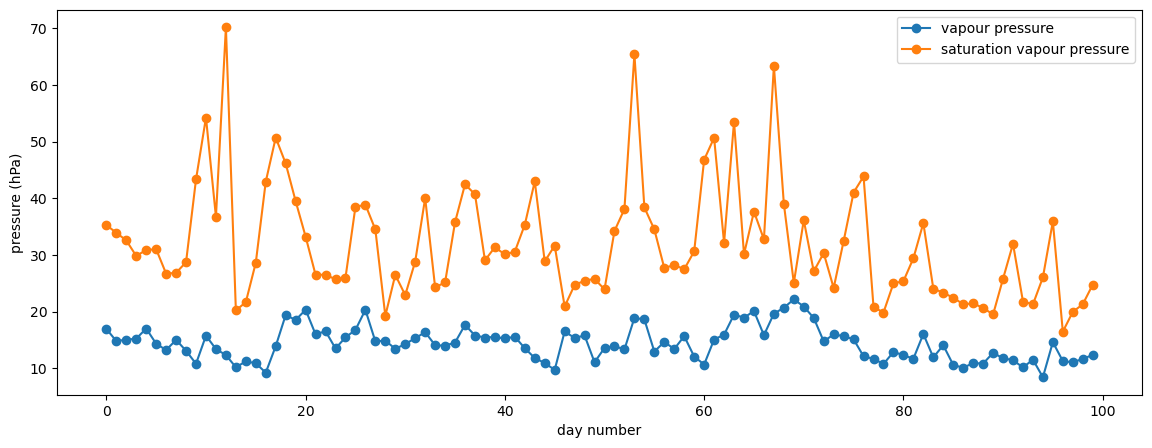

In [20]:
lat, lon = city_lat_lon['Melbourne']
point_vp = da_agcd_vp.sel({'lat': lat, 'lon': lon}, method='nearest')
point_vps = da_agcd_vps.sel({'lat': lat, 'lon': lon}, method='nearest')

fig = plt.figure(figsize=[14, 5])
plt.plot(point_vp.values[1:101], marker='o', label='vapour pressure')
plt.plot(point_vps.values[0:100] / 100, marker='o', label='saturation vapour pressure')

plt.ylabel('pressure (hPa)')
plt.xlabel('day number')
plt.legend()
plt.show()

In [21]:
daily_hurs = (da_agcd_vp[1:].values / (da_agcd_vps.values / 100)) * 100 

In [22]:
coords = {
    'time': ds_agcd_tmin['time'][1:],
    'lat': ds_agcd_tmin['lat'],
    'lon': ds_agcd_tmin['lon'],
}

da_agcd_hurs = xr.DataArray(
    data = daily_hurs,
    dims = ('time', 'lat', 'lon'),
    coords = coords,
)
da_agcd_hurs.attrs['long_name'] = 'Surface relative humidity'
da_agcd_hurs.attrs['units'] = '%'

ds_agcd_hurs = xr.Dataset({'hurs': da_agcd_hurs})

In [23]:
era5_file = '/g/data/dk7/processed/staging/users/cxh599_ua6/GlobalObs_and_Reanalysis/processed/aus0.05/ERA-5/day/hurs/hurs_ERA-5_day_aus0.05_2016.nc'

In [24]:
era5_ds = xr.open_mfdataset(era5_file)

In [30]:
barra2_files = sorted(glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/hurs/hurs_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_2016*.nc'))

In [32]:
barra2_ds = xr.open_mfdataset(barra2_files)

In [34]:
barra2_ds

<xarray.Dataset>
Dimensions:    (time: 366, lat: 646, lon: 1082, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lat        (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon        (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    hurs       (time, lat, lon) float32 dask.array<chunksize=(31, 646, 1082), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:                  0.1.0
    axiom_schemas_version:          0.1.0
    axiom_schema:                   cordex-1D.json
    Conventions:                    CF-1.9, ACDD-1.3
    source:                         Data from Met Office Unified Model
    project:                        ACS-BARRA2
    ...                             ...
    publisher_institution:          Bureau of Meteorology
    publisher_name:                 Bureau of Meteorology
    creator_institution:            Bureau of Meteorology
    keywords:                       Earth Science Services, Models; Continent...
    title:                          Bureau of Meteorology Atmospheric high-re...
    summary:                        The Bureau of Meteorology Atmospheric hig...

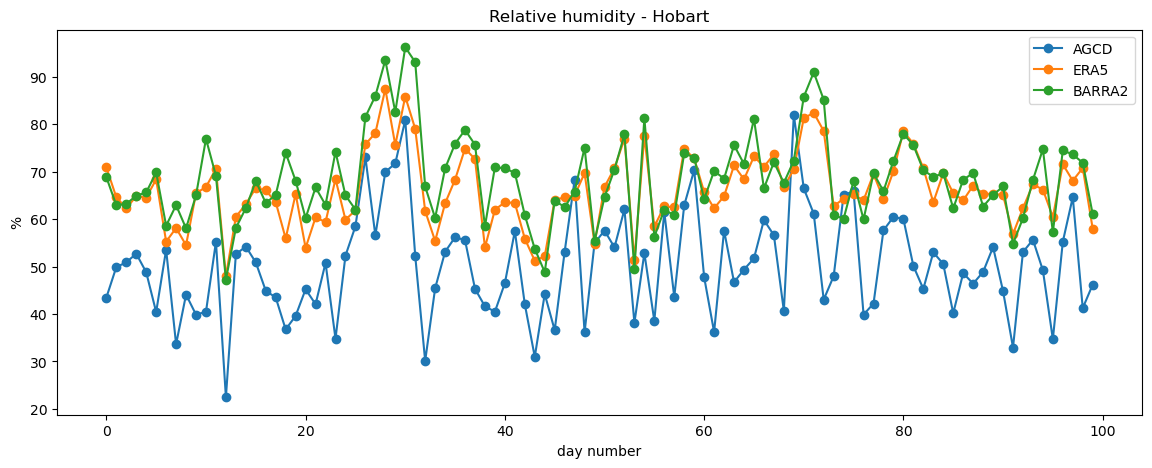

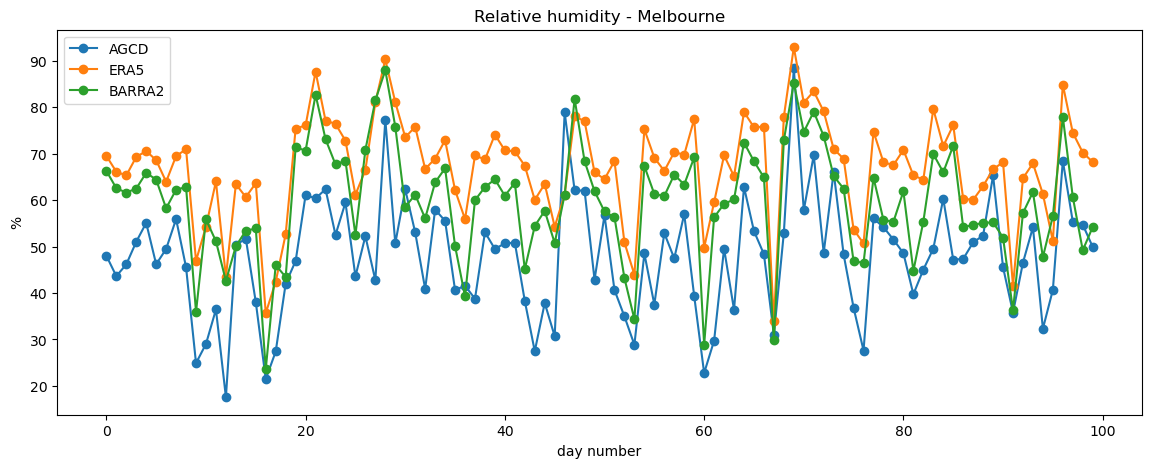

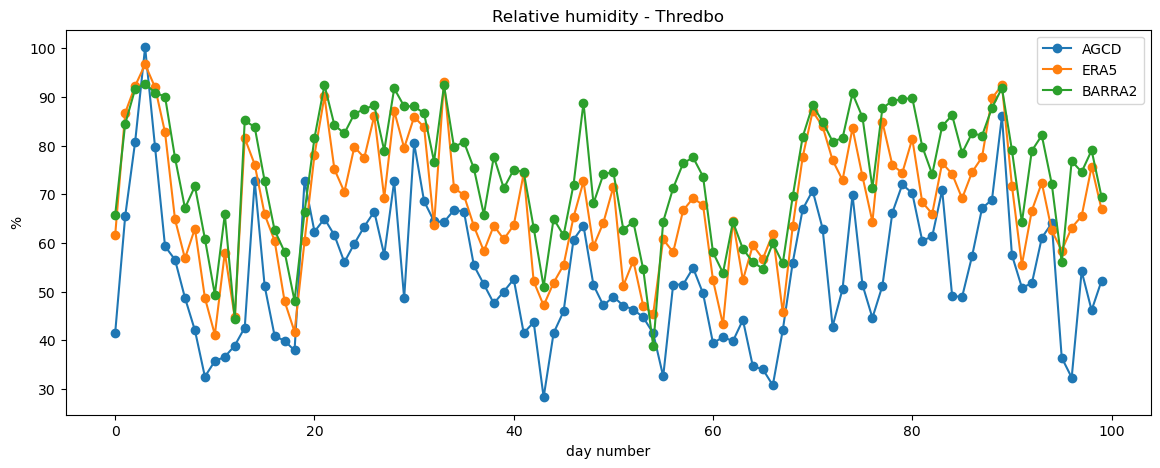

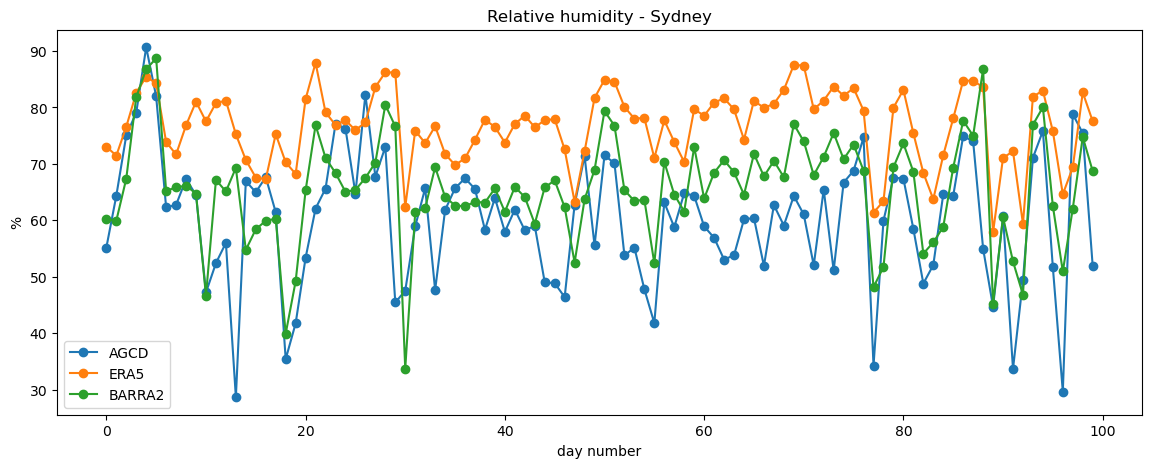

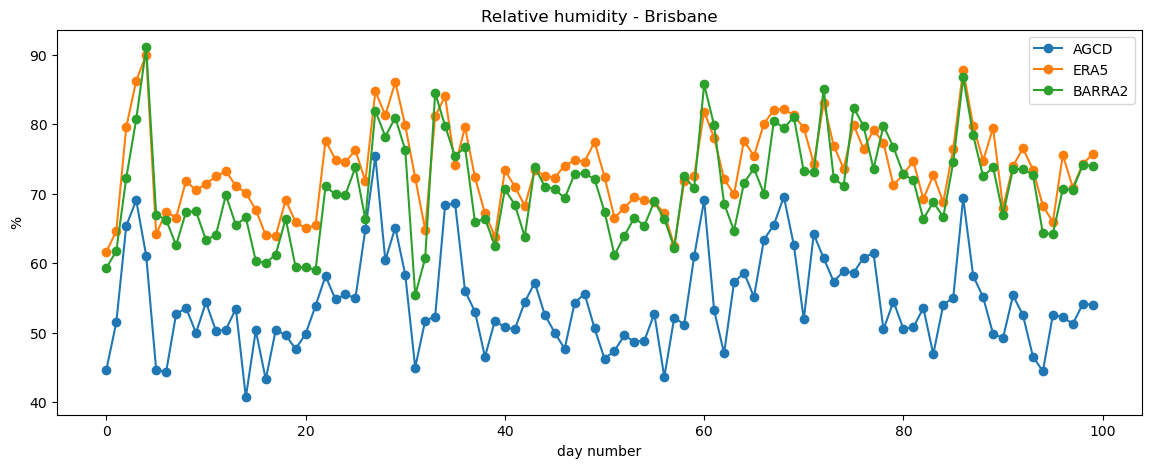

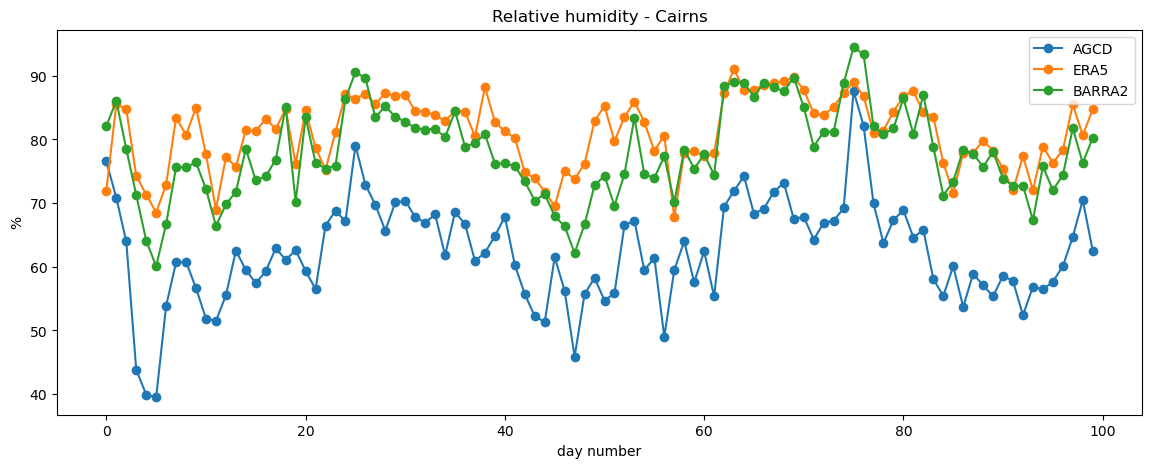

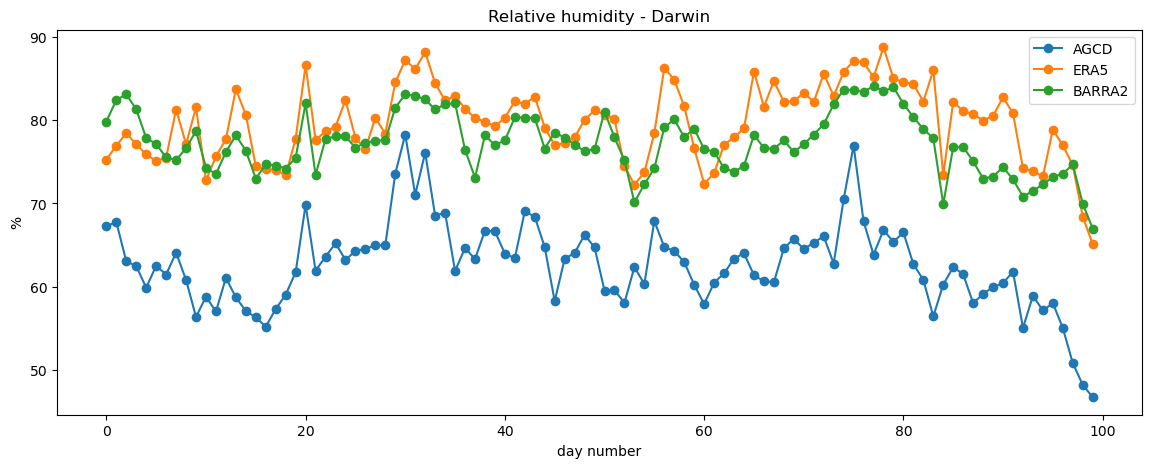

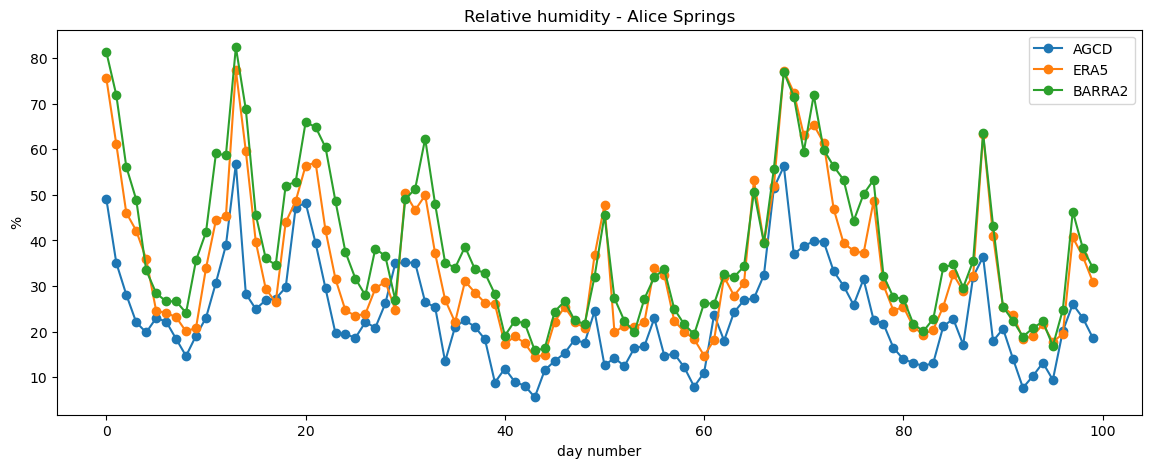

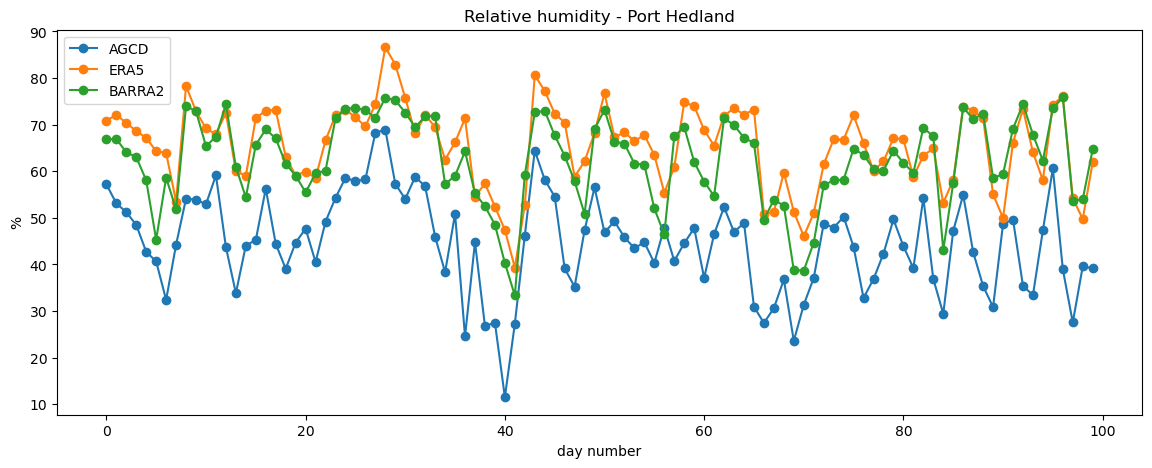

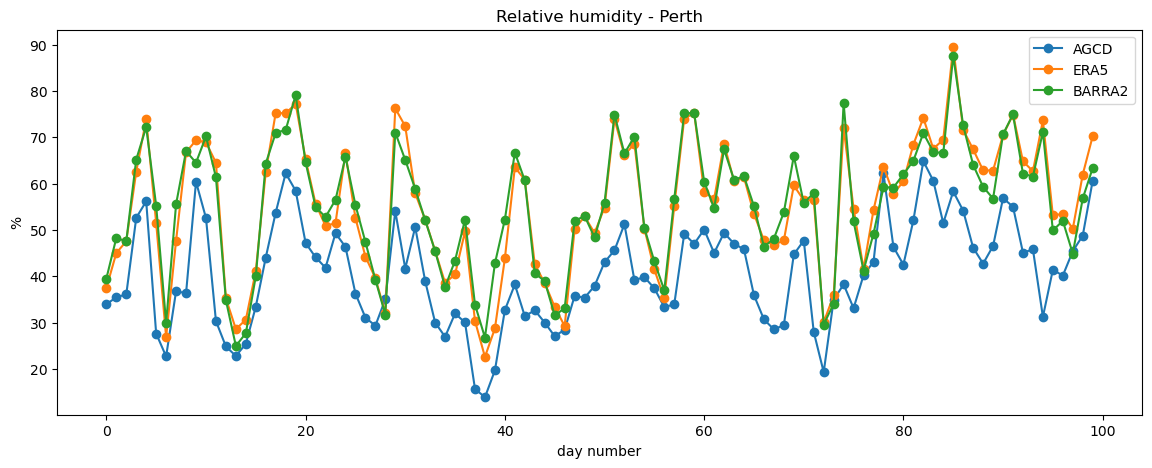

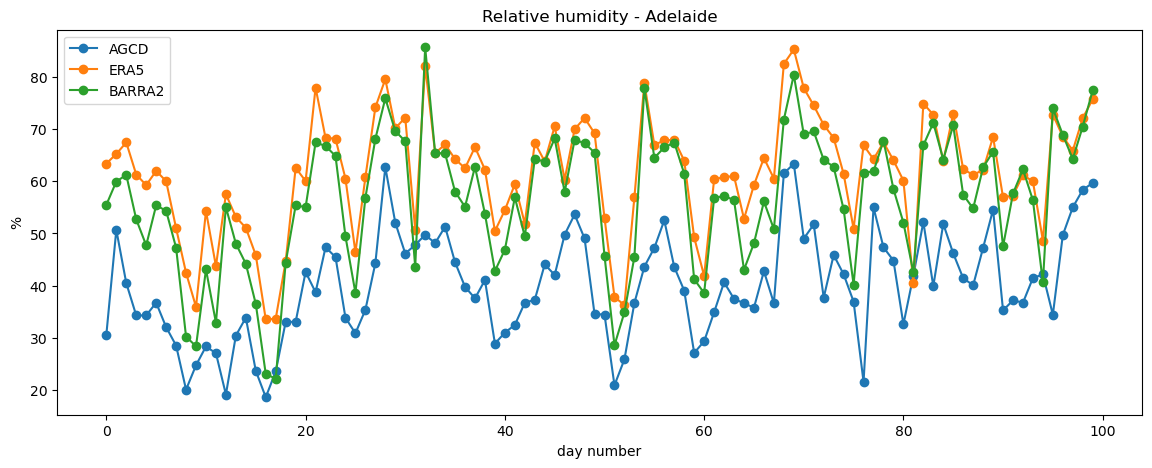

In [38]:
for city in city_lat_lon:
    lat, lon = city_lat_lon[city]
    point_agcd_hurs = da_agcd_hurs.sel({'lat': lat, 'lon': lon}, method='nearest')
    point_era5_hurs = era5_ds['hurs'].sel({'lat': lat, 'lon': lon}, method='nearest')
    point_barra2_hurs = barra2_ds['hurs'].sel({'lat': lat, 'lon': lon}, method='nearest')
    fig = plt.figure(figsize=[14, 5])
    plt.plot(point_agcd_hurs.values[0:100], marker='o', label='AGCD')
    plt.plot(point_era5_hurs.values[0:100], marker='o', label='ERA5')
    plt.plot(point_barra2_hurs.values[0:100], marker='o', label='BARRA2')
    plt.ylabel('%')
    plt.xlabel('day number')
    plt.legend()
    plt.title(f'Relative humidity - {city}')
    plt.show()

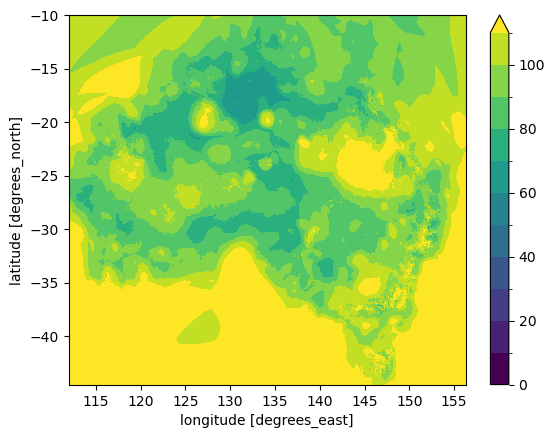

In [56]:
da_agcd_hurs.max('time').plot(levels=[0,10,20,30,40,50,60,70,80,90,100,110])